In [1]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MeanIoU, Precision, Recall
from PIL import Image
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

2024-06-26 04:08:28.000027: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-26 04:08:28.000162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-26 04:08:28.142510: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Define image and mask folders
image_folder = "/kaggle/input/livecelldataset/LSD/images/livecell_train_val_images"
mask_folder = "/kaggle/input/livecelldataset/LSD/annotations/LIVECell_single_cells"

In [3]:
# List all class directories
class_directories = os.listdir(image_folder)

In [4]:
# Lists to store images and masks
images = []
masks = []

# Shuffle class directories
np.random.shuffle(class_directories)

# Create a dictionary to store image filenames for each class
train_image_dict = {class_name: [] for class_name in class_directories}

# Load images and their corresponding masks from each class
for class_name in class_directories:
    image_paths = glob(os.path.join(image_folder, class_name, "*.tif"))
    print(class_name, end = '')
    for image_path in tqdm(image_paths):
        mask_filename = os.path.basename(image_path)
        mask_path = os.path.join(mask_folder, class_name, "train", mask_filename)
        

        if os.path.exists(mask_path):
            # Load images and masks
            img = plt.imread(image_path)
            mask = plt.imread(mask_path)

            images.append(img)
            masks.append(mask)
            train_image_dict[class_name].append(mask_filename)

# Print the number of images initially
print(f"Number of images initially: {len(images)}")

skbr3

100%|██████████| 528/528 [00:11<00:00, 44.48it/s]


a172

100%|██████████| 456/456 [00:09<00:00, 47.85it/s]


bt474

100%|██████████| 504/504 [00:09<00:00, 53.08it/s]


mcf7

100%|██████████| 552/552 [00:11<00:00, 49.38it/s]


huh7

100%|██████████| 400/400 [00:07<00:00, 54.65it/s]


skov3

100%|██████████| 304/304 [00:05<00:00, 51.86it/s]


shsy5y

100%|██████████| 528/528 [00:11<00:00, 47.93it/s]


bv2

100%|██████████| 456/456 [00:09<00:00, 49.68it/s]

Number of images initially: 3727


In [5]:
images, masks = shuffle(images, masks)

In [6]:
# images = images[0:20]
# masks = masks[0:20]

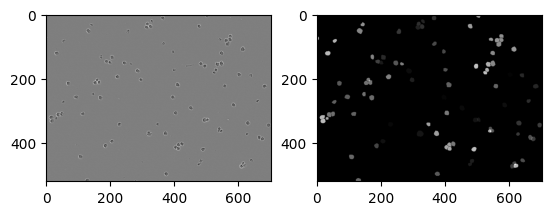

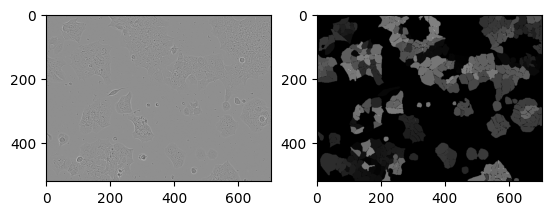

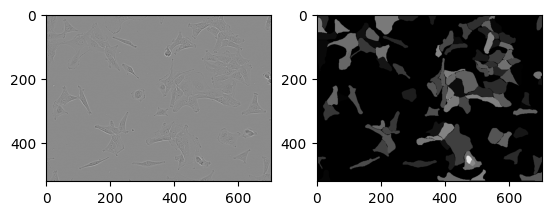

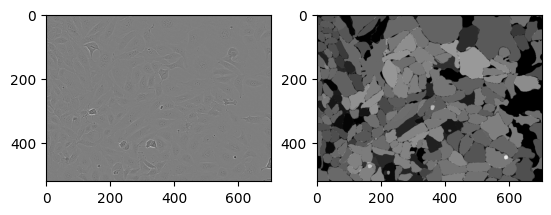

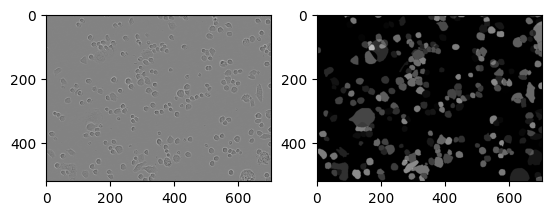

In [7]:
for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(images[i], cmap = 'gray')
    
    plt.subplot(1,2,2)
    plt.imshow(masks[i], cmap = 'gray')
    
    plt.show()

In [8]:
import cv2
# Preprocessing functions
def preprocess_image(image):
    resized_image = cv2.resize(image, (128,128), interpolation=cv2.INTER_NEAREST) #resize(image, [128, 128])  # Resize the image to 256x256
    #normalized_image = resized_image / 255.0  # Normalize pixel values to range 0-1
    return resized_image

def masks_to_binary(mask):
    binary_mask = np.where(mask > 0, 1, 0)  # Convert mask to binary array
    return binary_mask

#Pre-processing
images_preprocessed = []

for i in tqdm(images):
    img = preprocess_image(i)
    images_preprocessed.append(img)

masks_preprocessed = []

for i in tqdm(masks):
    mask = preprocess_image(i)
    mask = masks_to_binary(mask)
    masks_preprocessed.append(mask)

100%|██████████| 3727/3727 [00:00<00:00, 9762.94it/s] 


In [9]:
images_preprocessed = np.array(images_preprocessed)

In [10]:
masks_preprocessed = np.array(masks_preprocessed)

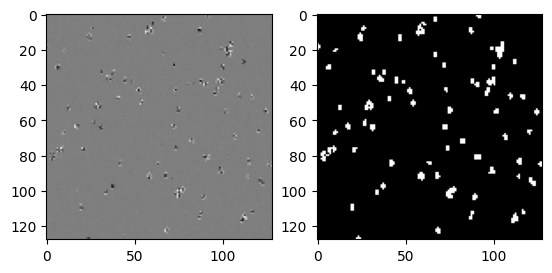

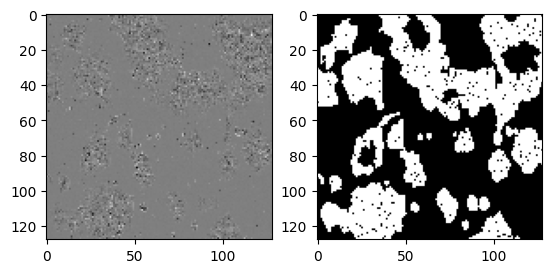

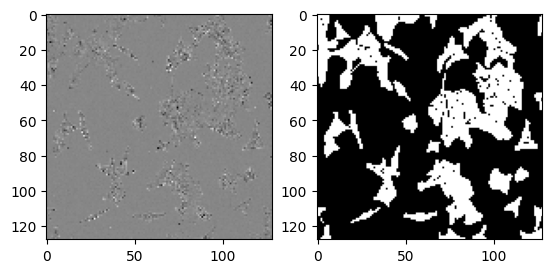

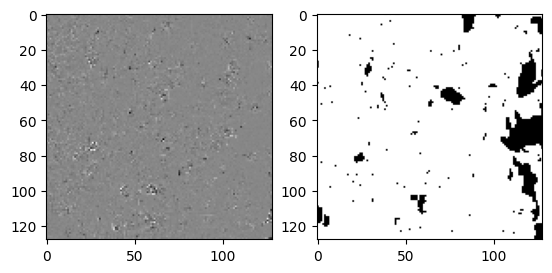

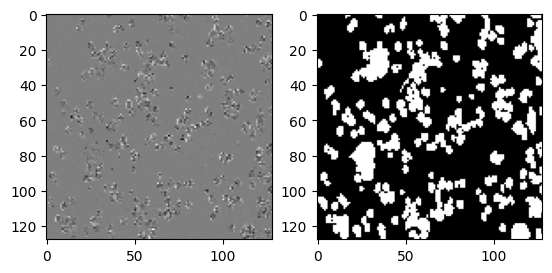

In [11]:
for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(images_preprocessed[i], cmap = 'gray')
    
    plt.subplot(1,2,2)
    plt.imshow(masks_preprocessed[i], cmap = 'gray')
    
    plt.show()

In [12]:
def compute_localsd_map(image, window_size=3):
    pad_size = window_size // 2
    padded_image = np.pad(image, pad_size, mode='reflect')
    localsd_map = np.zeros_like(image, dtype=float)

    # Compute local standard deviation 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            local_region = padded_image[i:i + window_size, j:j + window_size]
            localsd_map[i, j] = np.std(local_region)

    localsd_map = (localsd_map - np.min(localsd_map)) / (np.max(localsd_map) - np.min(localsd_map))
    return localsd_map




def compute_laplacian_map(image):
    # Apply a Laplacian filter to approximate second derivatives
    laplacian_filter = np.array([[1,  1, 1],
                                 [1, -8, 1],
                                 [1,  1, 1]])
    
    laplacian_map = np.abs(convolve2d(image, laplacian_filter, mode='same', boundary='wrap'))
    laplacian_map = (laplacian_map - np.min(laplacian_map)) / (np.max(laplacian_map) - np.min(laplacian_map))
    return laplacian_map


def convolve2d(image, kernel, mode='same', boundary='wrap'):
    """A simple 2d convolution implementation."""
    kernel = np.flipud(np.fliplr(kernel))    # Flip the kernel
    output = np.zeros_like(image)
    image_padded = np.pad(image, ((kernel.shape[0]//2, kernel.shape[1]//2),), mode=boundary)
    
    for x in range(image.shape[1]):    
        for y in range(image.shape[0]):
            # element-wise multiplication of the kernel and the image
            output[y, x]=(kernel*image_padded[y:y+kernel.shape[0], x:x+kernel.shape[1]]).sum()
    return output

In [13]:
X = []

for image in tqdm(images_preprocessed):
     # Ensure the image is normalized to [0, 1]
    image_normalized =  (image-image.min())/(image.max()-image.min())

    # Compute the feature maps
    localsd_map = compute_localsd_map(image_normalized)
    laplacian_map = compute_laplacian_map(image_normalized)

    feature_stacked_image = np.dstack((localsd_map, laplacian_map, image_normalized))

    # Append the feature stacked image to the new list
    X.append(feature_stacked_image)

# Convert the list to a NumPy array if needed
X = np.array(X)

100%|██████████| 3727/3727 [42:31<00:00,  1.46it/s]


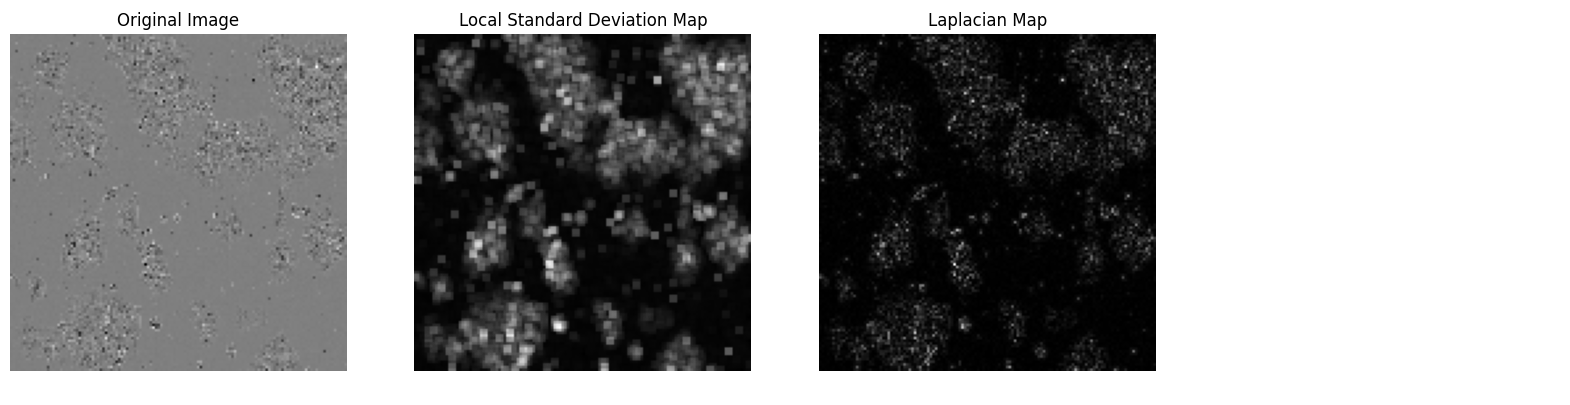

In [15]:
import matplotlib.pyplot as plt

# Assuming X is your array of fused feature maps and images
fused_feature_map = X[1]  # Taking the first fused feature map for demonstration

# Split the fused feature map into its respective channels
original_image = fused_feature_map[:, :, 2]  # Assuming the original image is the first channel
localsd_map = fused_feature_map[:, :, 0]    # Assuming the saliency map is the second channel
laplacian_map = fused_feature_map[:, :, 1]    # Assuming the ballness map is the third channel

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # Creating a subplot with 1 row and 4 columns

axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')

axes[1].imshow(localsd_map, cmap='gray')
axes[1].set_title('Local Standard Deviation Map')

axes[2].imshow(laplacian_map, cmap='gray')
axes[2].set_title('Laplacian Map')

# Removing axes for better visualization
for ax in axes:
    ax.axis('off')

plt.show()

In [16]:
print('localsd Map - max:', np.max(localsd_map), 'min:', np.min(localsd_map), 'mean:', np.mean(localsd_map))
print('Laplacian Map - max:', np.max(laplacian_map), 'min:', np.min(laplacian_map), 'mean:', np.mean(laplacian_map))

localsd Map - max: 1.0 min: 0.0 mean: 0.15079637212390984
Laplacian Map - max: 1.0 min: 0.0 mean: 0.05022002984277951


In [16]:
y = masks_preprocessed

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1)

In [18]:
# Do this to save memory

X= []
y = []
masks_preprocessed = []
images_preprocessed = []

In [19]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate
from keras.optimizers import Adam

# Define early stopping criteria
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss for early stopping
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the model weights to the best epoch
)

def create_attention_unet(input_size=(128, 128, 3), n_filters=64, dropout=0.2, batch_norm=True):

    def attention(input_tensor, g, inter_shape):
        input_shapes = input_tensor.shape
        x = tf.keras.layers.Conv2D(inter_shape, 1, 2, padding="same")(input_tensor)
        g = tf.keras.layers.Conv2D(inter_shape, 1, padding="same")(g)
        add = tf.keras.layers.add([x, g])
        relu = tf.keras.layers.Activation('relu')(x)
        psi = tf.keras.layers.Conv2D(1, 1, padding="same")(relu)
        sigmoid = tf.keras.layers.Activation('sigmoid')(psi)
        upsample = tf.keras.layers.UpSampling2D(size=(2, 2))(sigmoid)
        att = tf.keras.layers.multiply([upsample, input_tensor])
        output = tf.keras.layers.Conv2D(input_shapes[3], 1, padding="same")(att)
        return tf.keras.layers.BatchNormalization()(output)

    def conv_block(input_tensor, n_filters):
        x_save = tf.keras.layers.Conv2D(n_filters, 3, activation="relu", padding="same")(input_tensor)
        if batch_norm:
            x = tf.keras.layers.BatchNormalization()(x_save)
        x = tf.keras.layers.Conv2D(n_filters, 3, activation="relu", padding="same")(x)
        if batch_norm:
            x = tf.keras.layers.BatchNormalization()(x)
        if dropout:
            x = tf.keras.layers.Dropout(dropout)(x)
        x = tf.keras.layers.add([x, x_save])
        x = tf.keras.layers.Activation("relu")(x)
        return x

    def downsample(x, n_filters):
        res_conn = conv_block(x, n_filters)
        x = tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2))(res_conn)
        return x, res_conn

    def upsample(x, n_filters, skip_conn):
        att = attention(skip_conn, x, n_filters)
        x = tf.keras.layers.Conv2DTranspose(n_filters, (2, 2), strides=2, padding="same", activation="relu")(x)
        x = tf.keras.layers.Concatenate()([x, att])
        x = conv_block(x, n_filters)
        if dropout:
            x = tf.keras.layers.Dropout(dropout)(x)
        if batch_norm:
            x = tf.keras.layers.BatchNormalization()(x)
        return x

    inputs = tf.keras.layers.Input(shape=input_size)

    x, skip_conn1 = downsample(inputs, n_filters)
    x, skip_conn2 = downsample(x, n_filters * 2)
    x, skip_conn3 = downsample(x, n_filters * 4)
    x, skip_conn4 = downsample(x, n_filters * 8)

    x = conv_block(x, n_filters * 16)

    x = upsample(x, n_filters * 8, skip_conn4)
    x = upsample(x, n_filters * 4, skip_conn3)
    x = upsample(x, n_filters * 2, skip_conn2)
    x = upsample(x, n_filters, skip_conn1)

    outputs = tf.keras.layers.Conv2D(1, (1,1), activation="sigmoid", padding="same")(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [20]:
@tf.keras.utils.register_keras_serializable()
def iou(y_true, y_pred):
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    y_true_f = tf.cast(y_true, tf.float32)
    y_pred_f = tf.cast(y_pred, tf.float32)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + 1e-7) / (union + 1e-7)

@tf.keras.utils.register_keras_serializable()
def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)

In [21]:
def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Adjust y_pred to match the shape of y_true
    if len(y_pred.shape) == 4 and y_pred.shape[-1] == 1:
        y_pred = tf.squeeze(y_pred, axis=-1)

    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    denominator = tf.reduce_sum(y_true + y_pred, axis=[1, 2])
    return 1 - (numerator + 1) / (denominator + 1)

In [22]:
def create_compile_model():
    model = create_attention_unet()  # Create your model
    model.compile(optimizer=Adam(learning_rate=0.001),  # You can adjust the learning rate as needed
                  loss='binary_crossentropy',
                  metrics=[iou, Precision(), Recall(), dice_coefficient])
    return model

In [23]:
def ema_update(teacher_model, student_model, alpha):
    """Exponential moving average update."""
    for t, s in zip(teacher_model.variables, student_model.variables):
        # Cast tensors to float32 before the operation to ensure data type compatibility
        t_value_float = tf.cast(t, tf.float32)
        s_value_float = tf.cast(s, tf.float32)
        updated_t_value = t_value_float * alpha + s_value_float * (1 - alpha)
        # Assign the updated value back to the teacher model's variable
        t.assign(updated_t_value)

def consistency_loss(y_teacher, y_student, weight=1.0):
    """Mean squared error between teacher and student outputs."""
    return weight * tf.reduce_mean((y_teacher - y_student)**2)

In [24]:
def iou_score(y_true, y_pred, smooth=1e-6):
    """
    Calculate the Intersection over Union (IoU) score between ground truth and predictions.

    Parameters:
    - y_true: Ground truth labels.
    - y_pred: Predicted labels.
    - smooth: A small float added to avoid division by zero.

    Returns:
    - IoU score as a float.
    """
    # Ensure y_pred matches the shape of y_true
    if len(y_pred.shape) == 4 and y_pred.shape[-1] == 1:
        y_pred = tf.squeeze(y_pred, axis=-1)
    
    # Cast both tensors to float32 to ensure type compatibility
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Calculate intersection and union areas
    intersection = tf.reduce_sum(y_true * y_pred)
    total = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    union = total - intersection
    
    # Compute IoU score
    iou = (intersection + smooth) / (union + smooth)
    return iou


def dice_score(y_true, y_pred, smooth=1):
    # Ensure y_pred matches the shape of y_true
    if len(y_pred.shape) == 4 and y_pred.shape[-1] == 1:
        y_pred = tf.squeeze(y_pred, axis=-1)
    
    # Cast both tensors to float32 to ensure type compatibility
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)

#### Testing set

In [25]:
test_image_folder = "/kaggle/input/livecelldataset/LSD/images/livecell_test_images"
test_mask_folder = "/kaggle/input/livecelldataset/LSD/annotations/LIVECell_single_cells"

class_directories = os.listdir(test_image_folder)

test_images = []
test_masks = []
for class_name in class_directories:
    image_paths = glob(os.path.join(test_image_folder, class_name, "*.tif"))
    print(class_name, end = '')
    for image_path in tqdm(image_paths):
        mask_filename = os.path.basename(image_path)
        mask_path = os.path.join(test_mask_folder, class_name,"test", mask_filename)

        if os.path.exists(mask_path):
            img = plt.imread(image_path)
            mask = plt.imread(mask_path)

            test_images.append(img)
            test_masks.append(mask)
            
# test_images = test_images[0:10]
# test_masks = test_masks[0:10]

shsy5y

100%|██████████| 176/176 [00:04<00:00, 37.33it/s]


skov3

100%|██████████| 304/304 [00:07<00:00, 40.24it/s]


bv2

100%|██████████| 152/152 [00:04<00:00, 37.99it/s]


bt474

100%|██████████| 168/168 [00:04<00:00, 41.75it/s]


a172

100%|██████████| 152/152 [00:04<00:00, 36.89it/s]


huh7

100%|██████████| 200/200 [00:04<00:00, 40.53it/s]


skbr3

100%|██████████| 176/176 [00:04<00:00, 36.52it/s]


mcf7

100%|██████████| 184/184 [00:05<00:00, 35.13it/s]


In [26]:
test_images_preprocessed = []
for i in tqdm(test_images):
    img = preprocess_image(i)
    test_images_preprocessed.append(img)

test_masks_preprocessed = []
for i in tqdm(test_masks):
    mask = preprocess_image(i)
    mask = masks_to_binary(mask)
    test_masks_preprocessed.append(mask)

test_images_preprocessed = np.array(test_images_preprocessed)
test_masks_preprocessed = np.array(test_masks_preprocessed)

100%|██████████| 1512/1512 [00:00<00:00, 28255.92it/s]

100%|██████████| 1512/1512 [00:00<00:00, 12375.86it/s]


In [27]:
# Main Loop
X_test = []
y_test = test_masks_preprocessed 

for image in tqdm(test_images_preprocessed):
    # Ensure the image is normalized to [0, 1]
    #image_normalized = image / 255.0 if np.max(image) > 1 else image
    image_normalized =  (image-image.min())/(image.max()-image.min())

    # Compute the feature maps
    saliency_map = compute_saliency_map(image_normalized)
    ballness_map = compute_ballness_map(image_normalized)
#     orientation_map = compute_orientation_map(image_normalized)

    # Normalize the orientation map to the range [0, 1]
#     orientation_map_normalized = (orientation_map - np.min(orientation_map)) / (np.max(orientation_map) - np.min(orientation_map))

    # Stack the feature maps and the original image
#     feature_stacked_image = np.dstack((saliency_map, ballness_map, orientation_map_normalized, image_normalized))
    feature_stacked_image = np.dstack((saliency_map, ballness_map, image_normalized))
    
    # Append the feature stacked image to the new list
    X_test.append(feature_stacked_image)

# Convert the list to a NumPy array
X_test = np.array(X_test)

100%|██████████| 1512/1512 [17:14<00:00,  1.46it/s]


In [28]:
# Early stopping parameters
patience = 10
best_val_loss = float('inf')
patience_counter = 0

# To store validation losses
val_losses = []
avg_losses = []

# Initialize the models
student_model = create_compile_model()
teacher_model = tf.keras.models.clone_model(student_model)
teacher_model.set_weights(student_model.get_weights())

epochs = 100
batch_size = 8
ema_alpha = 0.99
consistency_weight = 1.0  
optimizer = Adam(learning_rate=0.0001)

# datagen = ImageDataGenerator(rotation_range=10, 
#                              width_shift_range=0.1,
#                              height_shift_range=0.1, 
#                              zoom_range=0.1,
#                              horizontal_flip=True, 
#                              vertical_flip=True,
#                              channel_shift_range=0.1)

checkpoint = ModelCheckpoint('MaUnet-best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

# 'labeled_frac' is the fraction of data that is labeled.
labeled_frac = 0.6

labeled_count = int(labeled_frac * len(X_train))

X_train_labeled = X_train[:labeled_count]
y_train_labeled = y_train[:labeled_count]
X_train_unlabeled = X_train[labeled_count:]

early_stop_triggered = False
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    total_loss_sum = 0
    total_loss_count = 0
    
    # Shuffle labeled and unlabeled data at the beginning of each epoch
    indices_labeled = np.arange(len(X_train_labeled))
    indices_unlabeled = np.arange(len(X_train_unlabeled))
    np.random.shuffle(indices_labeled)
    np.random.shuffle(indices_unlabeled)

    # Combine the batches of labeled and unlabeled data
    labeled_batches = np.array_split(indices_labeled, len(indices_labeled) // batch_size)
    unlabeled_batches = np.array_split(indices_unlabeled, len(indices_unlabeled) // batch_size)
    max_batches = max(len(labeled_batches), len(unlabeled_batches))
    
    # Loop over batches
    for i in range(max_batches):
        # Labeled data
        if i < len(labeled_batches):
            batch_indices = labeled_batches[i]
            X_batch_labeled = X_train_labeled[batch_indices]
            y_batch_labeled = y_train_labeled[batch_indices]
            
            # Train student on labeled data
            with tf.GradientTape() as tape:
                y_student_labeled = student_model(X_batch_labeled, training=True)
                sup_loss = dice_loss(y_batch_labeled, y_student_labeled)
            grads = tape.gradient(sup_loss, student_model.trainable_weights)
            optimizer.apply_gradients(zip(grads, student_model.trainable_weights))
            
            # Add to total loss sum if labeled data was used
            total_loss_sum += sup_loss.numpy().sum()
            total_loss_count += sup_loss.numpy().size

        # Unlabeled data
        if i < len(unlabeled_batches):
            batch_indices = unlabeled_batches[i]
            X_batch_unlabeled = X_train_unlabeled[batch_indices]
            
            # Get pseudo-labels from teacher model
            y_teacher_unlabeled = teacher_model(X_batch_unlabeled, training=False)
            
            # Apply consistency loss between teacher and student on unlabeled data
            with tf.GradientTape() as tape:
                y_student_unlabeled = student_model(X_batch_unlabeled, training=True)
                cons_loss = consistency_loss(y_teacher_unlabeled, y_student_unlabeled, consistency_weight)
            grads = tape.gradient(cons_loss, student_model.trainable_weights)
            optimizer.apply_gradients(zip(grads, student_model.trainable_weights))

    # After processing all labeled and unlabeled batches
    ema_update(teacher_model, student_model, ema_alpha)

    # Calculate average loss for the epoch if we had labeled data
    avg_loss = total_loss_sum / total_loss_count if total_loss_count > 0 else 0

    # Validation on labeled data only
    val_loss = 0
    for j in range(0, len(X_val), batch_size):
        X_batch_val = X_val[j:j+batch_size]
        y_batch_val = y_val[j:j+batch_size]
        # Ensure consistent preprocessing for X_batch_val as applied to X_train
        y_val_pred = teacher_model.predict(X_batch_val)
        y_val_pred = tf.squeeze(y_val_pred, axis=-1)  # Ensure prediction shape matches target
        val_loss += tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_batch_val, y_val_pred)).numpy()

    val_loss_mean = val_loss / len(X_val)  # Mean validation loss

    val_losses.append(float(f"{val_loss_mean:.4f}"))
    avg_losses.append(float(f"{avg_loss:.4f}"))

    # Early Stopping Check
    if val_loss_mean < best_val_loss:
        best_val_loss = val_loss_mean
        patience_counter = 0
        teacher_model.save('MaUnet-best_model.keras')  # Save the best performing model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            early_stop_triggered = True
            break  # Exit the training loop

    print(f"Epoch {epoch + 1} - avg_loss: {avg_loss:.4f}")

Epoch 1/100

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step



I0000 00:00:1712089650.751121      78 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [29]:
training_set_prediction = student_model.predict(X_train)

105/105 ━━━━━━━━━━━━━━━━━━━━ 86s 455ms/step


In [30]:
training_set_prediction = student_model.predict(X_train)

105/105 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step


Training set predictions


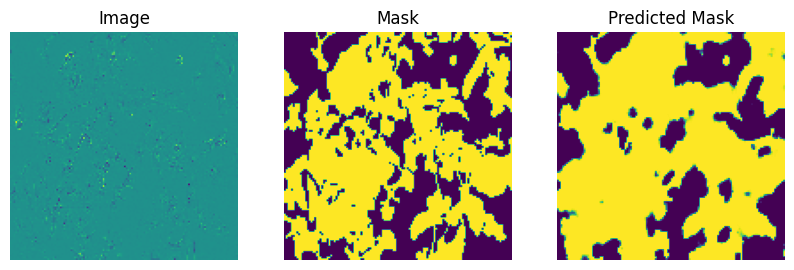

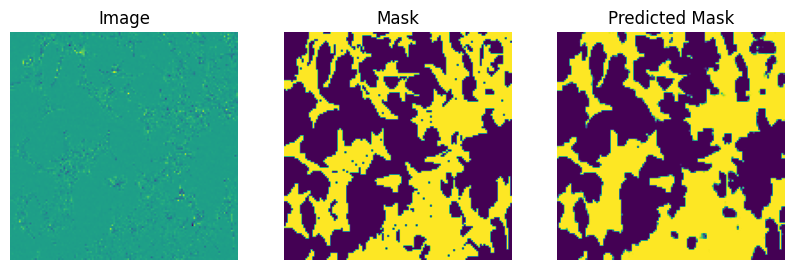

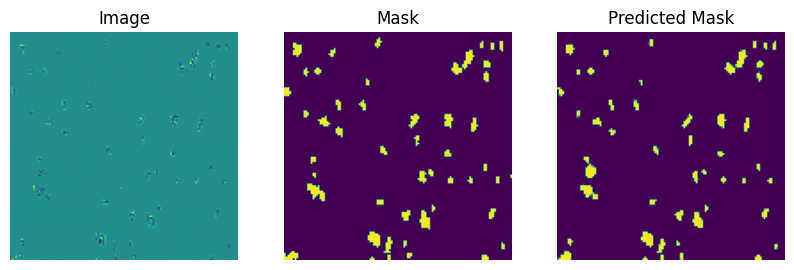

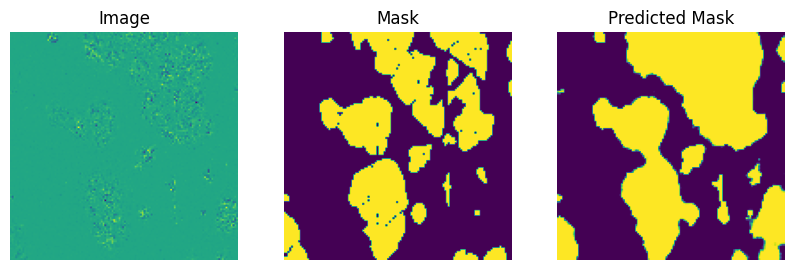

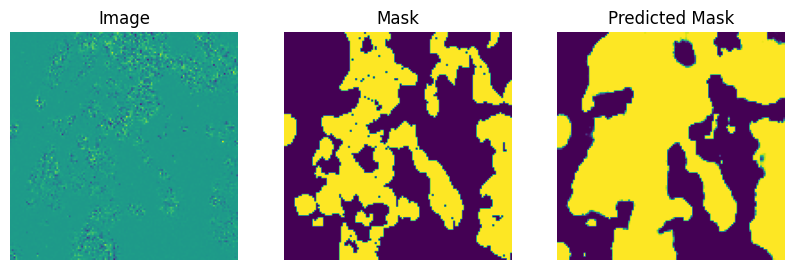

In [31]:
print("Training set predictions")
for i in range(5):
    plt.figure(figsize=(10, 4)) 
    
    # Image
    plt.subplot(1, 3, 1)
    plt.imshow(X_train[i][:, :, 2]) 
    plt.title("Image")
    plt.axis('off')  # Hide axes ticks
    
    # Mask
    plt.subplot(1, 3, 2)
    plt.imshow(y_train[i])  
    plt.title("Mask")
    plt.axis('off')
    
    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(training_set_prediction[i])
    plt.title("Predicted Mask")
    plt.axis('off')
    
    plt.show()

Training set predictions


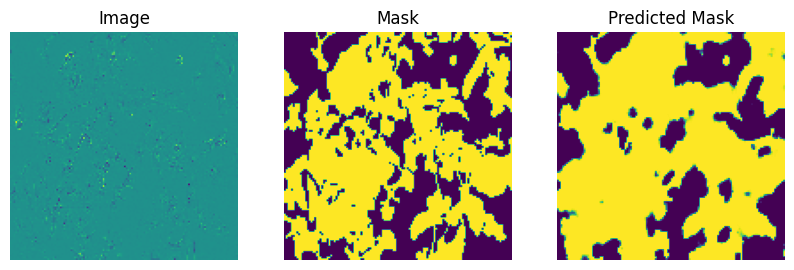

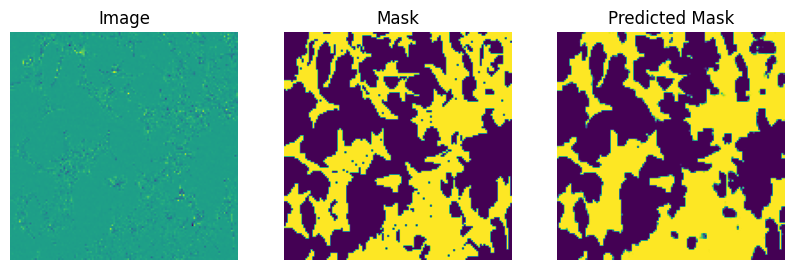

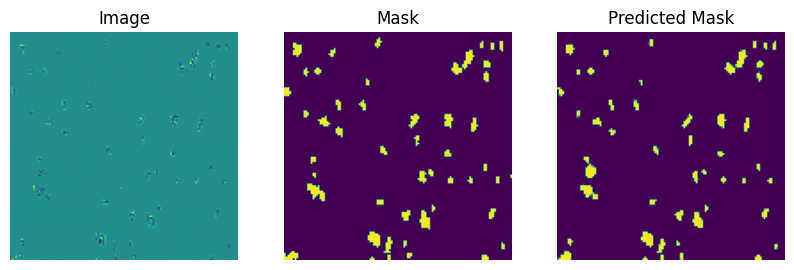

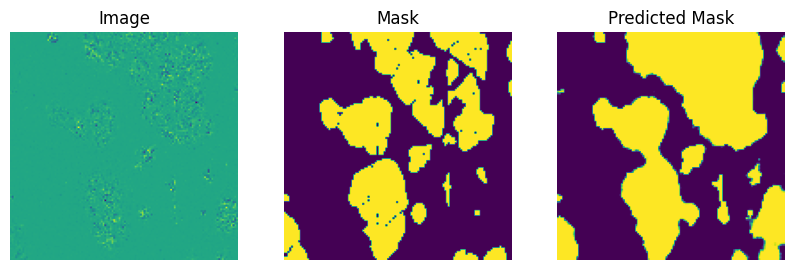

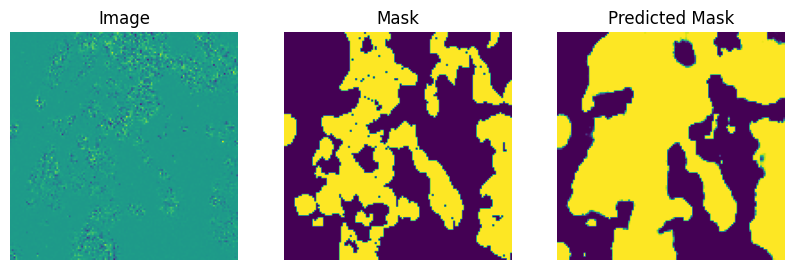

In [32]:
print("Training set predictions")
for i in range(5):
    plt.figure(figsize=(10, 4)) 
    
    # Image
    plt.subplot(1, 3, 1)
    plt.imshow(X_train[i][:, :, 2]) 
    plt.title("Image")
    plt.axis('off')  # Hide axes ticks
    
    # Mask
    plt.subplot(1, 3, 2)
    plt.imshow(y_train[i])  
    plt.title("Mask")
    plt.axis('off')
    
    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(training_set_prediction[i])
    plt.title("Predicted Mask")
    plt.axis('off')
    
    plt.show()

In [33]:
y_pred = student_model.predict(X_test)

48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step


Testing set predictions


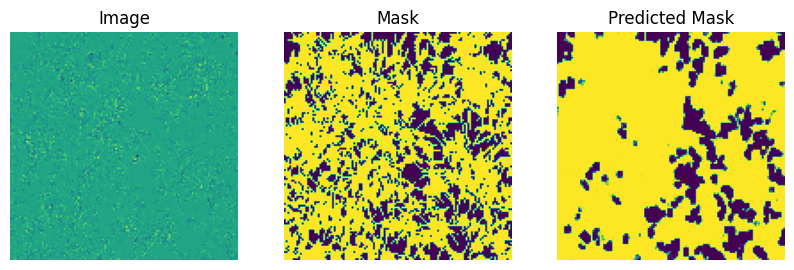

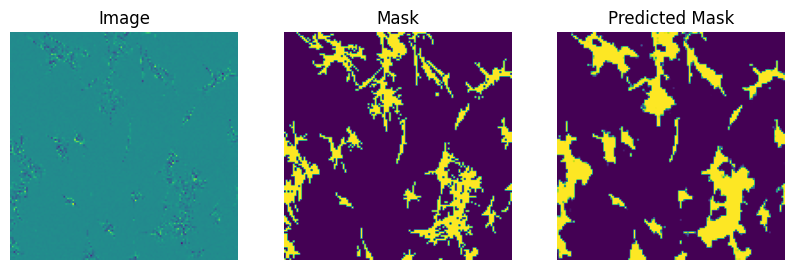

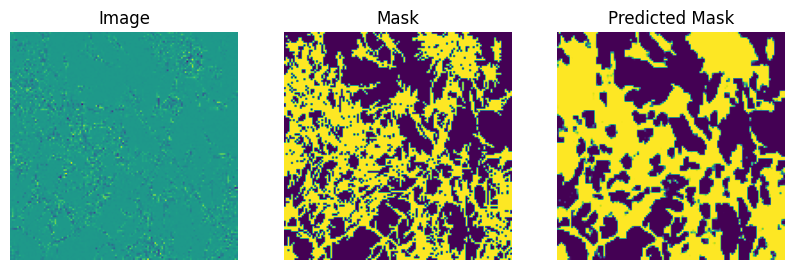

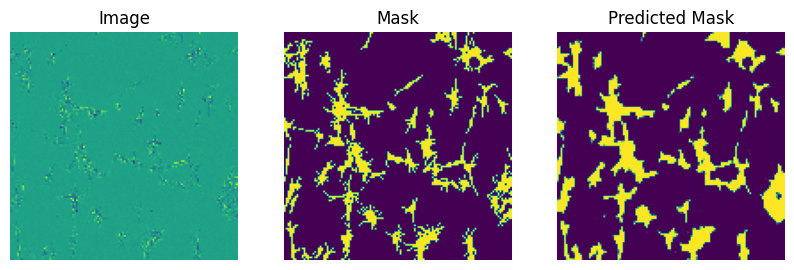

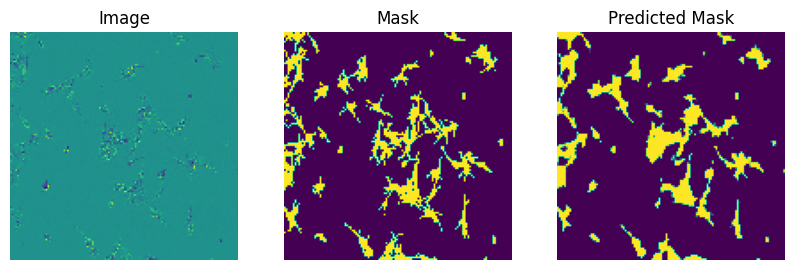

In [34]:
print("Testing set predictions")
for i in range(5):
    plt.figure(figsize=(10, 4)) 
    
    # Image
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i][:, :, 2]) 
    plt.title("Image")
    plt.axis('off')  # Hide axes ticks
    
    # Mask
    plt.subplot(1, 3, 2)
    plt.imshow(y_test[i])  
    plt.title("Mask")
    plt.axis('off')
    
    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(y_pred[i])
    plt.title("Predicted Mask")
    plt.axis('off')
    
    plt.show()

In [35]:
print(f"IOU Score: {iou_score(y_test, y_pred).numpy()}")
print(f"Dice Score: {dice_score(y_test, y_pred).numpy()}")

IOU Score: 0.7908132076263428

Dice Score: 0.8831889629364014


In [36]:
teacher_model.save('Teacher_model.keras')

In [37]:
student_model.save("Student_model.keras")

# **A172**

In [38]:
test_image_folder = "/kaggle/input/livecelldataset/LSD/images/livecell_test_images"
test_mask_folder = "/kaggle/input/livecelldataset/LSD/annotations/LIVECell_single_cells"

class_name = "a172"  # Specify the class name you want to fetch

image_paths = glob(os.path.join(test_image_folder, class_name, "*.tif"))

test_images = []
test_masks = []

for image_path in image_paths:
    mask_filename = os.path.basename(image_path)
    mask_path = os.path.join(test_mask_folder, class_name, "test", mask_filename)

    if os.path.exists(mask_path):
        img = plt.imread(image_path)
        mask = plt.imread(mask_path)

        test_images.append(img)
        test_masks.append(mask)

test_images_preprocessed = []
for i in tqdm(test_images):
    img = preprocess_image(i)
    test_images_preprocessed.append(img)

test_masks_preprocessed = []
for i in tqdm(test_masks):
    mask = preprocess_image(i)
    mask = masks_to_binary(mask)
    test_masks_preprocessed.append(mask)

test_images_preprocessed = np.array(test_images_preprocessed)
test_masks_preprocessed = np.array(test_masks_preprocessed)


100%|██████████| 152/152 [00:00<00:00, 25214.93it/s]

100%|██████████| 152/152 [00:00<00:00, 11357.36it/s]


In [39]:
# Main Loop
X_test = []
y_test = test_masks_preprocessed 

for image in tqdm(test_images_preprocessed):
    # Ensure the image is normalized to [0, 1]
    image_normalized =  (image-image.min())/(image.max()-image.min())

    # Compute the feature maps
    saliency_map = compute_saliency_map(image_normalized)
    ballness_map = compute_ballness_map(image_normalized)
#     orientation_map = compute_orientation_map(image_normalized)

    # Normalize the orientation map to the range [0, 1]
#     orientation_map_normalized = (orientation_map - np.min(orientation_map)) / (np.max(orientation_map) - np.min(orientation_map))

    # Stack the feature maps and the original image
#     feature_stacked_image = np.dstack((saliency_map, ballness_map, orientation_map_normalized, image_normalized))
    feature_stacked_image = np.dstack((saliency_map, ballness_map, image_normalized))
    
    # Append the feature stacked image to the new list
    X_test.append(feature_stacked_image)

# Convert the list to a NumPy array
X_test = np.array(X_test)

100%|██████████| 152/152 [01:44<00:00,  1.46it/s]


In [40]:
y_pred = student_model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 8s/step


In [41]:
print(f"IOU Score: {iou_score(y_test, y_pred).numpy()}")
print(f"Dice Score: {dice_score(y_test, y_pred).numpy()}")

IOU Score: 0.8794384002685547

Dice Score: 0.9358523488044739


Testing set predictions


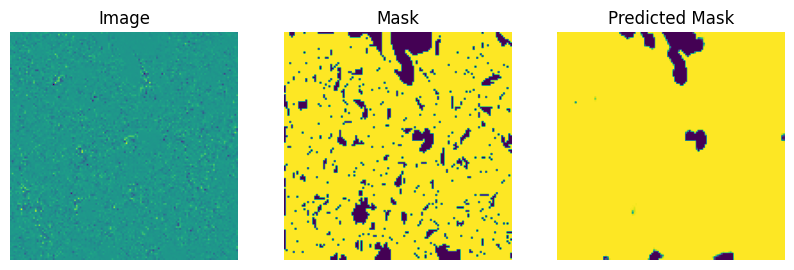

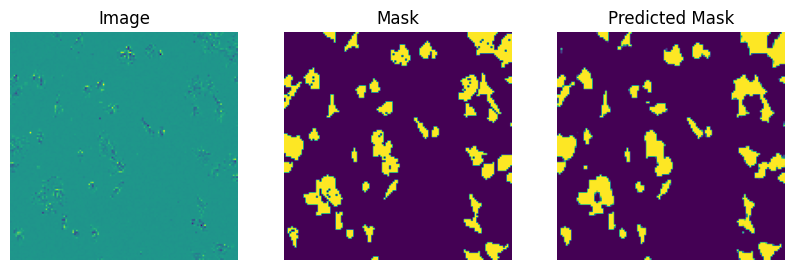

In [42]:
print("Testing set predictions")
for i in range(2):
    plt.figure(figsize=(10, 4)) 
    
    # Image
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i][:, :, 2]) 
    plt.title("Image")
    plt.axis('off')  # Hide axes ticks
    
    # Mask
    plt.subplot(1, 3, 2)
    plt.imshow(y_test[i])  
    plt.title("Mask")
    plt.axis('off')
    
    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(y_pred[i])
    plt.title("Predicted Mask")
    plt.axis('off')
    
    plt.show()

# **BT474**

In [43]:
test_image_folder = "/kaggle/input/livecelldataset/LSD/images/livecell_test_images"
test_mask_folder = "/kaggle/input/livecelldataset/LSD/annotations/LIVECell_single_cells"

class_name = "bt474"  # Specify the class name you want to fetch

image_paths = glob(os.path.join(test_image_folder, class_name, "*.tif"))

test_images = []
test_masks = []

for image_path in image_paths:
    mask_filename = os.path.basename(image_path)
    mask_path = os.path.join(test_mask_folder, class_name, "test", mask_filename)

    if os.path.exists(mask_path):
        img = plt.imread(image_path)
        mask = plt.imread(mask_path)

        test_images.append(img)
        test_masks.append(mask)

test_images_preprocessed = []
for i in tqdm(test_images):
    img = preprocess_image(i)
    test_images_preprocessed.append(img)

test_masks_preprocessed = []
for i in tqdm(test_masks):
    mask = preprocess_image(i)
    mask = masks_to_binary(mask)
    test_masks_preprocessed.append(mask)

test_images_preprocessed = np.array(test_images_preprocessed)
test_masks_preprocessed = np.array(test_masks_preprocessed)


100%|██████████| 168/168 [00:00<00:00, 26630.50it/s]

100%|██████████| 168/168 [00:00<00:00, 12356.09it/s]


In [44]:
# Main Loop
X_test = []
y_test = test_masks_preprocessed 

for image in tqdm(test_images_preprocessed):
    # Ensure the image is normalized to [0, 1]
    image_normalized =  (image-image.min())/(image.max()-image.min())

    # Compute the feature maps
    saliency_map = compute_saliency_map(image_normalized)
    ballness_map = compute_ballness_map(image_normalized)
#     orientation_map = compute_orientation_map(image_normalized)

    # Normalize the orientation map to the range [0, 1]
#     orientation_map_normalized = (orientation_map - np.min(orientation_map)) / (np.max(orientation_map) - np.min(orientation_map))

    # Stack the feature maps and the original image
#     feature_stacked_image = np.dstack((saliency_map, ballness_map, orientation_map_normalized, image_normalized))
    feature_stacked_image = np.dstack((saliency_map, ballness_map, image_normalized))
    
    # Append the feature stacked image to the new list
    X_test.append(feature_stacked_image)

# Convert the list to a NumPy array
X_test = np.array(X_test)

100%|██████████| 168/168 [01:53<00:00,  1.47it/s]


In [45]:
y_pred = student_model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


In [46]:
print(f"IOU Score: {iou_score(y_test, y_pred).numpy()}")
print(f"Dice Score: {dice_score(y_test, y_pred).numpy()}")

IOU Score: 0.7183528542518616

Dice Score: 0.8360947966575623


Testing set predictions


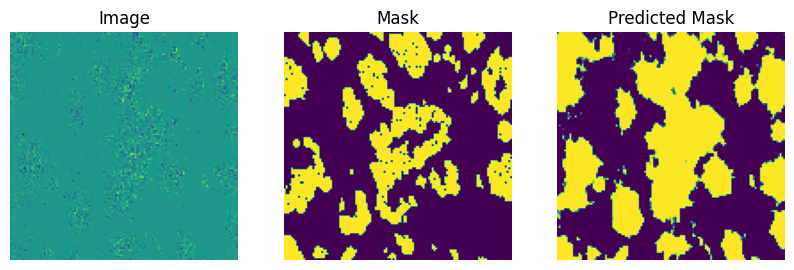

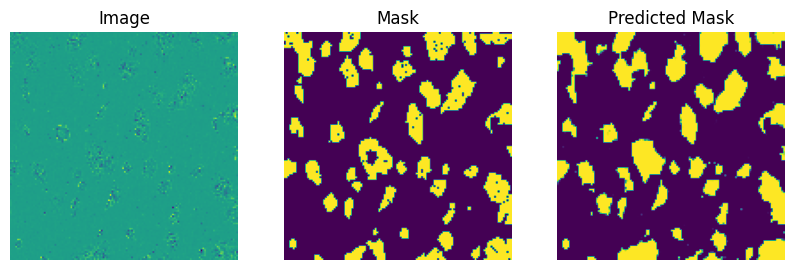

In [47]:
print("Testing set predictions")
for i in range(2):
    plt.figure(figsize=(10, 4)) 
    
    # Image
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i][:, :, 2]) 
    plt.title("Image")
    plt.axis('off')  # Hide axes ticks
    
    # Mask
    plt.subplot(1, 3, 2)
    plt.imshow(y_test[i])  
    plt.title("Mask")
    plt.axis('off')
    
    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(y_pred[i])
    plt.title("Predicted Mask")
    plt.axis('off')
    
    plt.show()

# **BV2**

In [48]:
test_image_folder = "/kaggle/input/livecelldataset/LSD/images/livecell_test_images"
test_mask_folder = "/kaggle/input/livecelldataset/LSD/annotations/LIVECell_single_cells"

class_name = "bv2"  # Specify the class name you want to fetch

image_paths = glob(os.path.join(test_image_folder, class_name, "*.tif"))

test_images = []
test_masks = []

for image_path in image_paths:
    mask_filename = os.path.basename(image_path)
    mask_path = os.path.join(test_mask_folder, class_name, "test", mask_filename)

    if os.path.exists(mask_path):
        img = plt.imread(image_path)
        mask = plt.imread(mask_path)

        test_images.append(img)
        test_masks.append(mask)

test_images_preprocessed = []
for i in tqdm(test_images):
    img = preprocess_image(i)
    test_images_preprocessed.append(img)

test_masks_preprocessed = []
for i in tqdm(test_masks):
    mask = preprocess_image(i)
    mask = masks_to_binary(mask)
    test_masks_preprocessed.append(mask)

test_images_preprocessed = np.array(test_images_preprocessed)
test_masks_preprocessed = np.array(test_masks_preprocessed)


100%|██████████| 152/152 [00:00<00:00, 23260.88it/s]

100%|██████████| 152/152 [00:00<00:00, 11499.33it/s]


In [49]:
# Main Loop
X_test = []
y_test = test_masks_preprocessed 

for image in tqdm(test_images_preprocessed):
    # Ensure the image is normalized to [0, 1]
    image_normalized =  (image-image.min())/(image.max()-image.min())

    # Compute the feature maps
    saliency_map = compute_saliency_map(image_normalized)
    ballness_map = compute_ballness_map(image_normalized)
#     orientation_map = compute_orientation_map(image_normalized)

    # Normalize the orientation map to the range [0, 1]
#     orientation_map_normalized = (orientation_map - np.min(orientation_map)) / (np.max(orientation_map) - np.min(orientation_map))

    # Stack the feature maps and the original image
#     feature_stacked_image = np.dstack((saliency_map, ballness_map, orientation_map_normalized, image_normalized))
    feature_stacked_image = np.dstack((saliency_map, ballness_map, image_normalized))
    
    # Append the feature stacked image to the new list
    X_test.append(feature_stacked_image)

# Convert the list to a NumPy array
X_test = np.array(X_test)

100%|██████████| 152/152 [01:44<00:00,  1.46it/s]


In [50]:
y_pred = student_model.predict(X_test)
print(f"IOU Score: {iou_score(y_test, y_pred).numpy()}")
print(f"Dice Score: {dice_score(y_test, y_pred).numpy()}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step

IOU Score: 0.6601511240005493

Dice Score: 0.7952905297279358


Testing set predictions


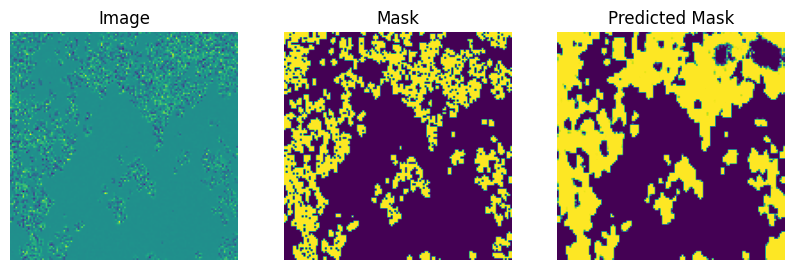

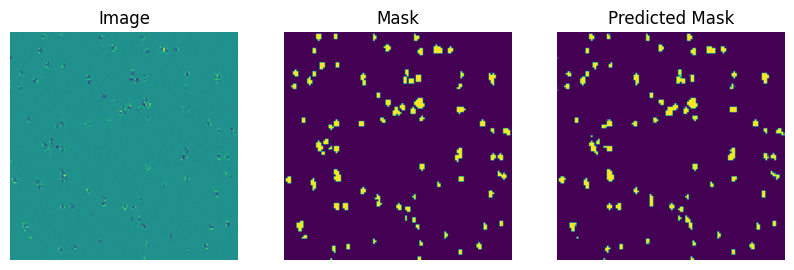

In [51]:
print("Testing set predictions")
for i in range(2):
    plt.figure(figsize=(10, 4)) 
    
    # Image
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i][:, :, 2]) 
    plt.title("Image")
    plt.axis('off')  # Hide axes ticks
    
    # Mask
    plt.subplot(1, 3, 2)
    plt.imshow(y_test[i])  
    plt.title("Mask")
    plt.axis('off')
    
    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(y_pred[i])
    plt.title("Predicted Mask")
    plt.axis('off')
    
    plt.show()

# **Huh7**

In [52]:
test_image_folder = "/kaggle/input/livecelldataset/LSD/images/livecell_test_images"
test_mask_folder = "/kaggle/input/livecelldataset/LSD/annotations/LIVECell_single_cells"

class_name = "huh7"  # Specify the class name you want to fetch

image_paths = glob(os.path.join(test_image_folder, class_name, "*.tif"))

test_images = []
test_masks = []

for image_path in image_paths:
    mask_filename = os.path.basename(image_path)
    mask_path = os.path.join(test_mask_folder, class_name, "test", mask_filename)

    if os.path.exists(mask_path):
        img = plt.imread(image_path)
        mask = plt.imread(mask_path)

        test_images.append(img)
        test_masks.append(mask)

test_images_preprocessed = []
for i in tqdm(test_images):
    img = preprocess_image(i)
    test_images_preprocessed.append(img)

test_masks_preprocessed = []
for i in tqdm(test_masks):
    mask = preprocess_image(i)
    mask = masks_to_binary(mask)
    test_masks_preprocessed.append(mask)

test_images_preprocessed = np.array(test_images_preprocessed)
test_masks_preprocessed = np.array(test_masks_preprocessed)


100%|██████████| 200/200 [00:00<00:00, 24653.52it/s]

100%|██████████| 200/200 [00:00<00:00, 12796.49it/s]


In [53]:
# Main Loop
X_test = []
y_test = test_masks_preprocessed 

for image in tqdm(test_images_preprocessed):
    # Ensure the image is normalized to [0, 1]
    image_normalized =  (image-image.min())/(image.max()-image.min())

    # Compute the feature maps
    saliency_map = compute_saliency_map(image_normalized)
    ballness_map = compute_ballness_map(image_normalized)
#     orientation_map = compute_orientation_map(image_normalized)

    # Normalize the orientation map to the range [0, 1]
#     orientation_map_normalized = (orientation_map - np.min(orientation_map)) / (np.max(orientation_map) - np.min(orientation_map))

    # Stack the feature maps and the original image
#     feature_stacked_image = np.dstack((saliency_map, ballness_map, orientation_map_normalized, image_normalized))
    feature_stacked_image = np.dstack((saliency_map, ballness_map, image_normalized))
    
    # Append the feature stacked image to the new list
    X_test.append(feature_stacked_image)

# Convert the list to a NumPy array
X_test = np.array(X_test)

100%|██████████| 200/200 [02:17<00:00,  1.46it/s]


In [54]:
y_pred = student_model.predict(X_test)
print(f"IOU Score: {iou_score(y_test, y_pred).numpy()}")
print(f"Dice Score: {dice_score(y_test, y_pred).numpy()}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step

IOU Score: 0.730268657207489

Dice Score: 0.8441102504730225


Testing set predictions


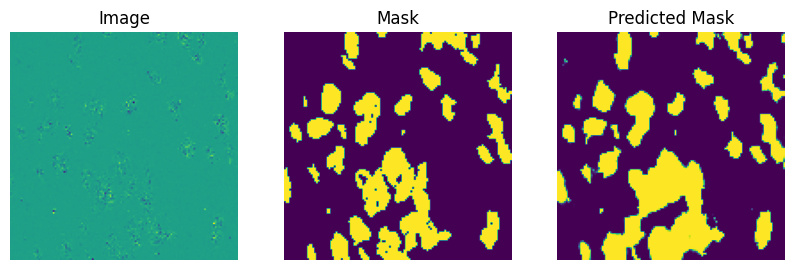

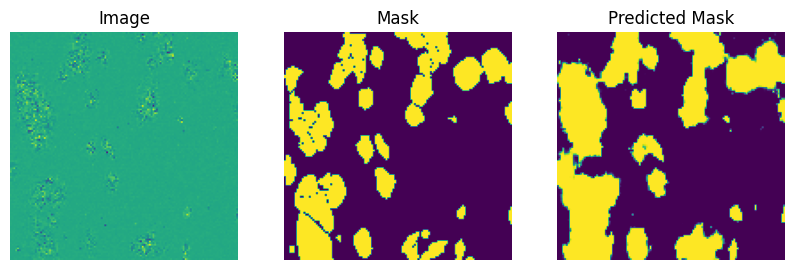

In [55]:
print("Testing set predictions")
for i in range(2):
    plt.figure(figsize=(10, 4)) 
    
    # Image
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i][:, :, 2]) 
    plt.title("Image")
    plt.axis('off')  # Hide axes ticks
    
    # Mask
    plt.subplot(1, 3, 2)
    plt.imshow(y_test[i])  
    plt.title("Mask")
    plt.axis('off')
    
    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(y_pred[i])
    plt.title("Predicted Mask")
    plt.axis('off')
    
    plt.show()

# **McF7**

In [56]:
test_image_folder = "/kaggle/input/livecelldataset/LSD/images/livecell_test_images"
test_mask_folder = "/kaggle/input/livecelldataset/LSD/annotations/LIVECell_single_cells"

class_name = "mcf7"  # Specify the class name you want to fetch

image_paths = glob(os.path.join(test_image_folder, class_name, "*.tif"))

test_images = []
test_masks = []

for image_path in image_paths:
    mask_filename = os.path.basename(image_path)
    mask_path = os.path.join(test_mask_folder, class_name, "test", mask_filename)

    if os.path.exists(mask_path):
        img = plt.imread(image_path)
        mask = plt.imread(mask_path)

        test_images.append(img)
        test_masks.append(mask)

test_images_preprocessed = []
for i in tqdm(test_images):
    img = preprocess_image(i)
    test_images_preprocessed.append(img)

test_masks_preprocessed = []
for i in tqdm(test_masks):
    mask = preprocess_image(i)
    mask = masks_to_binary(mask)
    test_masks_preprocessed.append(mask)

test_images_preprocessed = np.array(test_images_preprocessed)
test_masks_preprocessed = np.array(test_masks_preprocessed)


100%|██████████| 184/184 [00:00<00:00, 25686.53it/s]

100%|██████████| 184/184 [00:00<00:00, 10915.25it/s]


In [57]:
# Main Loop
X_test = []
y_test = test_masks_preprocessed 

for image in tqdm(test_images_preprocessed):
    # Ensure the image is normalized to [0, 1]
    image_normalized =  (image-image.min())/(image.max()-image.min())

    # Compute the feature maps
    saliency_map = compute_saliency_map(image_normalized)
    ballness_map = compute_ballness_map(image_normalized)
#     orientation_map = compute_orientation_map(image_normalized)

    # Normalize the orientation map to the range [0, 1]
#     orientation_map_normalized = (orientation_map - np.min(orientation_map)) / (np.max(orientation_map) - np.min(orientation_map))

    # Stack the feature maps and the original image
#     feature_stacked_image = np.dstack((saliency_map, ballness_map, orientation_map_normalized, image_normalized))
    feature_stacked_image = np.dstack((saliency_map, ballness_map, image_normalized))
    
    # Append the feature stacked image to the new list
    X_test.append(feature_stacked_image)

# Convert the list to a NumPy array
X_test = np.array(X_test)

100%|██████████| 184/184 [02:05<00:00,  1.47it/s]


In [58]:
y_pred = student_model.predict(X_test)
print(f"IOU Score: {iou_score(y_test, y_pred).numpy()}")
print(f"Dice Score: {dice_score(y_test, y_pred).numpy()}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step

IOU Score: 0.8174325823783875

Dice Score: 0.8995465636253357


Testing set predictions


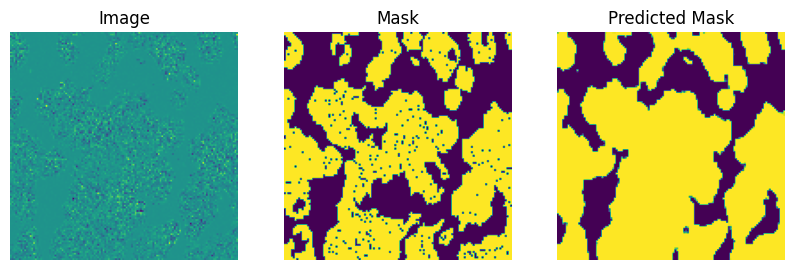

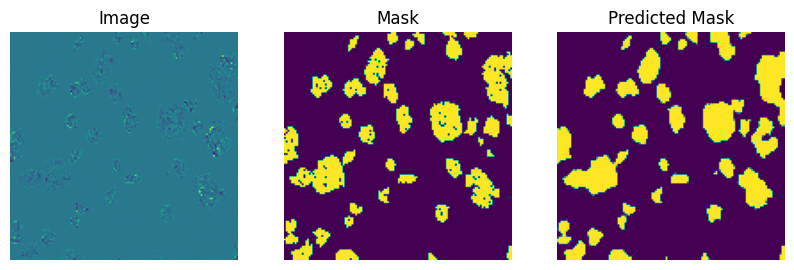

In [59]:
print("Testing set predictions")
for i in range(2):
    plt.figure(figsize=(10, 4)) 
    
    # Image
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i][:, :, 2]) 
    plt.title("Image")
    plt.axis('off')  # Hide axes ticks
    
    # Mask
    plt.subplot(1, 3, 2)
    plt.imshow(y_test[i])  
    plt.title("Mask")
    plt.axis('off')
    
    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(y_pred[i])
    plt.title("Predicted Mask")
    plt.axis('off')
    
    plt.show()

# **ShSY5Y**

In [60]:
test_image_folder = "/kaggle/input/livecelldataset/LSD/images/livecell_test_images"
test_mask_folder = "/kaggle/input/livecelldataset/LSD/annotations/LIVECell_single_cells"

class_name = "shsy5y"  # Specify the class name you want to fetch

image_paths = glob(os.path.join(test_image_folder, class_name, "*.tif"))

test_images = []
test_masks = []

for image_path in image_paths:
    mask_filename = os.path.basename(image_path)
    mask_path = os.path.join(test_mask_folder, class_name, "test", mask_filename)

    if os.path.exists(mask_path):
        img = plt.imread(image_path)
        mask = plt.imread(mask_path)

        test_images.append(img)
        test_masks.append(mask)

test_images_preprocessed = []
for i in tqdm(test_images):
    img = preprocess_image(i)
    test_images_preprocessed.append(img)

test_masks_preprocessed = []
for i in tqdm(test_masks):
    mask = preprocess_image(i)
    mask = masks_to_binary(mask)
    test_masks_preprocessed.append(mask)

test_images_preprocessed = np.array(test_images_preprocessed)
test_masks_preprocessed = np.array(test_masks_preprocessed)


100%|██████████| 176/176 [00:00<00:00, 20949.50it/s]

100%|██████████| 176/176 [00:00<00:00, 10111.05it/s]


In [61]:
# Main Loop
X_test = []
y_test = test_masks_preprocessed 

for image in tqdm(test_images_preprocessed):
    # Ensure the image is normalized to [0, 1]
    image_normalized =  (image-image.min())/(image.max()-image.min())

    # Compute the feature maps
    saliency_map = compute_saliency_map(image_normalized)
    ballness_map = compute_ballness_map(image_normalized)
#     orientation_map = compute_orientation_map(image_normalized)

    # Normalize the orientation map to the range [0, 1]
#     orientation_map_normalized = (orientation_map - np.min(orientation_map)) / (np.max(orientation_map) - np.min(orientation_map))

    # Stack the feature maps and the original image
#     feature_stacked_image = np.dstack((saliency_map, ballness_map, orientation_map_normalized, image_normalized))
    feature_stacked_image = np.dstack((saliency_map, ballness_map, image_normalized))
    
    # Append the feature stacked image to the new list
    X_test.append(feature_stacked_image)

# Convert the list to a NumPy array
X_test = np.array(X_test)

100%|██████████| 176/176 [01:57<00:00,  1.50it/s]


In [62]:
y_pred = student_model.predict(X_test)
print(f"IOU Score: {iou_score(y_test, y_pred).numpy()}")
print(f"Dice Score: {dice_score(y_test, y_pred).numpy()}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step

IOU Score: 0.6778331398963928

Dice Score: 0.8079864382743835


Testing set predictions


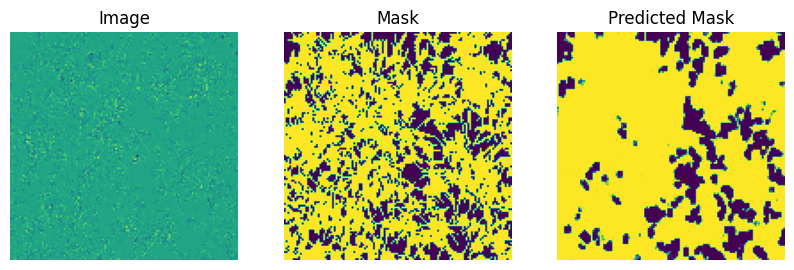

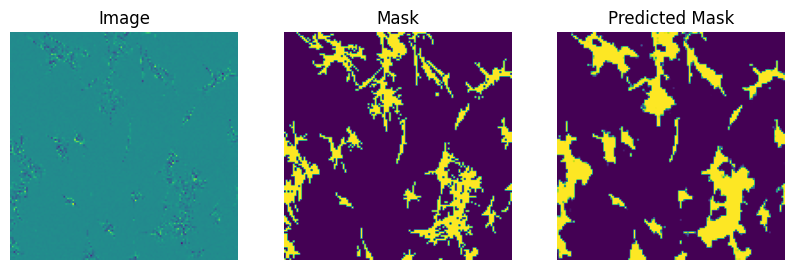

In [63]:
print("Testing set predictions")
for i in range(2):
    plt.figure(figsize=(10, 4)) 
    
    # Image
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i][:, :, 2]) 
    plt.title("Image")
    plt.axis('off')  # Hide axes ticks
    
    # Mask
    plt.subplot(1, 3, 2)
    plt.imshow(y_test[i])  
    plt.title("Mask")
    plt.axis('off')
    
    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(y_pred[i])
    plt.title("Predicted Mask")
    plt.axis('off')
    
    plt.show()

# **SkBR3**

In [64]:
test_image_folder = "/kaggle/input/livecelldataset/LSD/images/livecell_test_images"
test_mask_folder = "/kaggle/input/livecelldataset/LSD/annotations/LIVECell_single_cells"

class_name = "skbr3"  # Specify the class name you want to fetch

image_paths = glob(os.path.join(test_image_folder, class_name, "*.tif"))

test_images = []
test_masks = []

for image_path in image_paths:
    mask_filename = os.path.basename(image_path)
    mask_path = os.path.join(test_mask_folder, class_name, "test", mask_filename)

    if os.path.exists(mask_path):
        img = plt.imread(image_path)
        mask = plt.imread(mask_path)

        test_images.append(img)
        test_masks.append(mask)

test_images_preprocessed = []
for i in tqdm(test_images):
    img = preprocess_image(i)
    test_images_preprocessed.append(img)

test_masks_preprocessed = []
for i in tqdm(test_masks):
    mask = preprocess_image(i)
    mask = masks_to_binary(mask)
    test_masks_preprocessed.append(mask)

test_images_preprocessed = np.array(test_images_preprocessed)
test_masks_preprocessed = np.array(test_masks_preprocessed)


100%|██████████| 176/176 [00:00<00:00, 24576.27it/s]

100%|██████████| 176/176 [00:00<00:00, 11024.13it/s]


In [65]:
# Main Loop
X_test = []
y_test = test_masks_preprocessed 

for image in tqdm(test_images_preprocessed):
    # Ensure the image is normalized to [0, 1]
    image_normalized =  (image-image.min())/(image.max()-image.min())

    # Compute the feature maps
    saliency_map = compute_saliency_map(image_normalized)
    ballness_map = compute_ballness_map(image_normalized)
#     orientation_map = compute_orientation_map(image_normalized)

    # Normalize the orientation map to the range [0, 1]
#     orientation_map_normalized = (orientation_map - np.min(orientation_map)) / (np.max(orientation_map) - np.min(orientation_map))

    # Stack the feature maps and the original image
#     feature_stacked_image = np.dstack((saliency_map, ballness_map, orientation_map_normalized, image_normalized))
    feature_stacked_image = np.dstack((saliency_map, ballness_map, image_normalized))
    
    # Append the feature stacked image to the new list
    X_test.append(feature_stacked_image)

# Convert the list to a NumPy array
X_test = np.array(X_test)

100%|██████████| 176/176 [01:58<00:00,  1.48it/s]


In [66]:
y_pred = student_model.predict(X_test)
print(f"IOU Score: {iou_score(y_test, y_pred).numpy()}")
print(f"Dice Score: {dice_score(y_test, y_pred).numpy()}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step

IOU Score: 0.8140611052513123

Dice Score: 0.8975013494491577


Testing set predictions


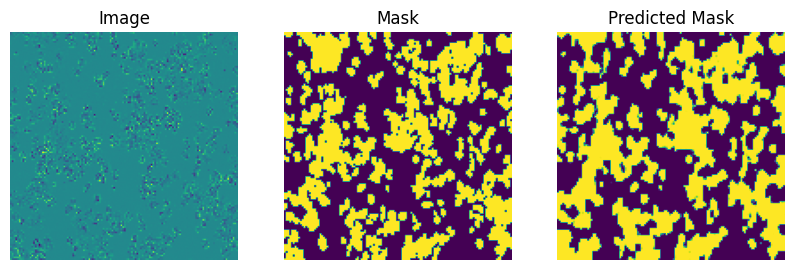

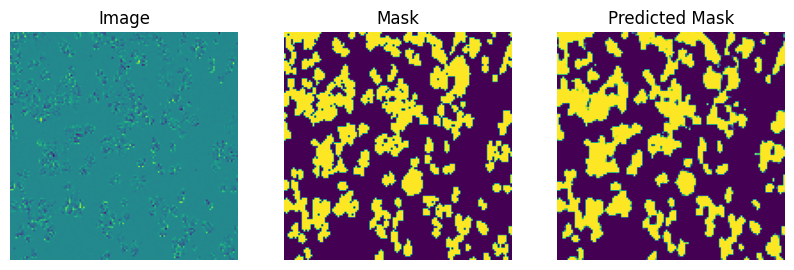

In [67]:
print("Testing set predictions")
for i in range(2):
    plt.figure(figsize=(10, 4)) 
    
    # Image
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i][:, :, 2]) 
    plt.title("Image")
    plt.axis('off')  # Hide axes ticks
    
    # Mask
    plt.subplot(1, 3, 2)
    plt.imshow(y_test[i])  
    plt.title("Mask")
    plt.axis('off')
    
    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(y_pred[i])
    plt.title("Predicted Mask")
    plt.axis('off')
    
    plt.show()

# **SkOV3**

In [68]:
test_image_folder = "/kaggle/input/livecelldataset/LSD/images/livecell_test_images"
test_mask_folder = "/kaggle/input/livecelldataset/LSD/annotations/LIVECell_single_cells"

class_name = "skov3"  # Specify the class name you want to fetch

image_paths = glob(os.path.join(test_image_folder, class_name, "*.tif"))

test_images = []
test_masks = []

for image_path in image_paths:
    mask_filename = os.path.basename(image_path)
    mask_path = os.path.join(test_mask_folder, class_name, "test", mask_filename)

    if os.path.exists(mask_path):
        img = plt.imread(image_path)
        mask = plt.imread(mask_path)

        test_images.append(img)
        test_masks.append(mask)

test_images_preprocessed = []
for i in tqdm(test_images):
    img = preprocess_image(i)
    test_images_preprocessed.append(img)

test_masks_preprocessed = []
for i in tqdm(test_masks):
    mask = preprocess_image(i)
    mask = masks_to_binary(mask)
    test_masks_preprocessed.append(mask)

test_images_preprocessed = np.array(test_images_preprocessed)
test_masks_preprocessed = np.array(test_masks_preprocessed)


100%|██████████| 304/304 [00:00<00:00, 25911.81it/s]

100%|██████████| 304/304 [00:00<00:00, 12283.19it/s]


In [69]:
# Main Loop
X_test = []
y_test = test_masks_preprocessed 

for image in tqdm(test_images_preprocessed):
    # Ensure the image is normalized to [0, 1]
    image_normalized =  (image-image.min())/(image.max()-image.min())

    # Compute the feature maps
    saliency_map = compute_saliency_map(image_normalized)
    ballness_map = compute_ballness_map(image_normalized)
#     orientation_map = compute_orientation_map(image_normalized)

    # Normalize the orientation map to the range [0, 1]
#     orientation_map_normalized = (orientation_map - np.min(orientation_map)) / (np.max(orientation_map) - np.min(orientation_map))

    # Stack the feature maps and the original image
#     feature_stacked_image = np.dstack((saliency_map, ballness_map, orientation_map_normalized, image_normalized))
    feature_stacked_image = np.dstack((saliency_map, ballness_map, image_normalized))
    
    # Append the feature stacked image to the new list
    X_test.append(feature_stacked_image)

# Convert the list to a NumPy array
X_test = np.array(X_test)

100%|██████████| 304/304 [03:24<00:00,  1.49it/s]


In [70]:
y_pred = student_model.predict(X_test)
print(f"IOU Score: {iou_score(y_test, y_pred).numpy()}")
print(f"Dice Score: {dice_score(y_test, y_pred).numpy()}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step

IOU Score: 0.8333685994148254

Dice Score: 0.9091119170188904


Testing set predictions


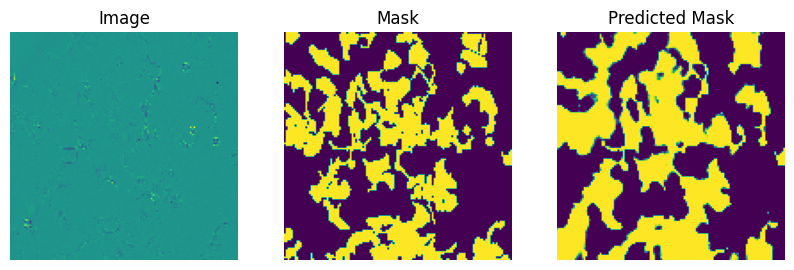

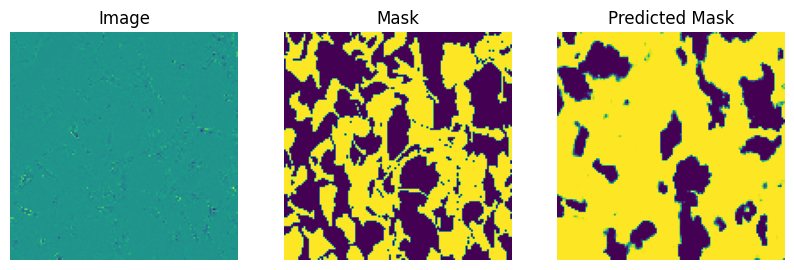

In [71]:
print("Testing set predictions")
for i in range(2):
    plt.figure(figsize=(10, 4)) 
    
    # Image
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i][:, :, 2]) 
    plt.title("Image")
    plt.axis('off')  # Hide axes ticks
    
    # Mask
    plt.subplot(1, 3, 2)
    plt.imshow(y_test[i])  
    plt.title("Mask")
    plt.axis('off')
    
    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(y_pred[i])
    plt.title("Predicted Mask")
    plt.axis('off')
    
    plt.show()

***